## Investigation into how the shortest paths in network models change between update steps of a dynamic topology: Edge Set Dynamics

In [12]:
import random 
import itertools
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 

**Graph Creation Method**
Graph Type: Small World (Watts Strogatz)

In [13]:
# Return every adjacent pair / edge in the ring lattice 
#       structure 
# Enumerate the edges in a ring lattice of degree k 
# nodes: Range/set of nodes in ring
# k: Number of neighbours of each node 
# return: List of edges as tuples (i, j)
def ring_adjacents(nodes, k):
    hk = int(np.floor(k / 2))
    
    edges = []
    for node in nodes:
        # Identify each adjacent node 
        for j in range((node + 1), (node + hk + 1)):
            v = nodes[j % len(nodes)]  # Modulo enforces loop back to start node  
            edges.append((node, v))
    
    return edges


# Create a networkx regular ring lattice network 
# n: Number of nodes
# k: Number of neighbours of each node
# return: Regular ring lattice as networkx graph 
def ring_network(n, k):
    nodes = range(n)
    edges = ring_adjacents(nodes, k)
    
    # Create networkx graph 
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G


# Watts-Strogatz Algorithm: Randomly rewire edges of given graph
# Graph expected is a regular ring lattice n, k 
# With given probability, p, each edge is randomly assigned a new destination
# G: Graph to rewire (networkx)
# p: Probability to rewire edge
def ws_rewire(G, p):
    for i, j in G.edges():
        if random.random() < p:
            G.remove_edge(i, j)
            nodes = [n for n in list(G.nodes) if n != i  and n not in G[i]]
            # Create new edge
            u, v = i, random.choice(nodes)
            G.add_edge(u, v)

            
# Generate a networkx graph with small world properties (Watts-Strogatz)     
def watts_strogatz(n, k, p):
    # Generate the edge list of a ring lattice 
    #     of size n and degree k 
    ring = ring_network(n, k)
    
    # Randomly reassign edges with probability p
    ws_rewire(ring, p)
    
    return ring

**Edge Set Dynamics:**  Below is the implementation of the function(s) to modify the edge set of a given graph for one time step. This is achieved by re-wiring edges to a new uniformly selected destination node with a given probability. 

In [ ]:
# With Probability Pr randomly rewire each edge to a new destination node
# Destination node must not be self, or already connected 
# G: Networkx Graph
# pr: Probability to rewire 
def dynamic_step_REWIRE(G, pr = 0.0):
    # For all edges 
    for i, j in G.edges():
        # With probability Pr 
        if random.random() < pr:            
            weight = G[i][j]['weight']
            
            if G.degree[j] == 1:
                continue 
                
            # Rewire the edge to from j to v
            G.remove_edge(i, j)
            nodes = [n for n in list(G.nodes) if n != i  and n not in G[i]]
            # Create new edge
            u, v = i, random.choice(nodes)
            G.add_edge(u, v, weight=weight)

**Utility Functions (Run all)**

In [15]:
# Randomly assign edge weights in range to graph
def assign_random_weights(G, wmin, wmax, w):
    if w is None:
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = np.random.uniform(low=wmin, high=wmax)
    else:
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = w

In [76]:
# Compute the shortest paths between all pairs of nodes
# in a weighted, undirected networkx graph 
# Djiksta's algorithm 
def nx_dijkstra(G, source):
    q = []        # Queue nodes to visit in traversal 
    dist = {}     # Distances from source
    prev = {}     # Previous node in path
    
    # Initialise distances to infinity 
    for node in list(G.nodes):
        dist[node] = float('inf')
        prev[node] = None 
        q.append(node) # Queue node for visiting 
        
    dist[source] = 0
    
    while q:
        # Take the node in q with the minimum distance from source
        min_ind, du = None, float('inf')
        for ind, node in enumerate(q):
            if dist[node] < du:
                min_ind, du = ind, dist[node]
        
        # Change u from index to node value
        # Remove u from q 
        u = q.pop(min_ind)
        
        # For every neighbour of u in q
        for v in list(G[u]):
            if v not in q:
                continue 
            
            alt = dist[u] + G[u][v]['weight']
             
            # Select the shortest path to v
            if alt < dist[v]:
                dist[v] = alt
                prev[v] = u
            
    return dist, prev

In [17]:
# Function to calculate Djikstra's shortest path (distances and paths)
# between all pairs of nodes (node n is source for every node n in G)
def all_shortest_paths(G):
    distances = []
    paths = []
    
    for src in list(G.nodes):
        d, p = nx_dijkstra(G, src)
        
        distances.append(d)
        paths.append(p)
    
    return distances, paths

In [18]:
# Function to calculate the average path length 
# The is the mean of all the shortest paths between 
#     all pairs of vertices 
# The shortest paths are calculated using Djikstra's deterministic algorithm 
def average_path_length(G):
    total_length = 0.0 
    
    # For every source node 
    for src in list(G.nodes):
        # Calculate the shortest path to all other nodes 
        d, p = nx_dijkstra(G, src)
        
        # Add each path length to the total
        total_length += sum(d.values())
    
    # Shortest paths were computed for n(n-1) pairs of nodes
    # Calculate mean path length
    return (total_length / (G.number_of_nodes() * (G.number_of_nodes() - 1)))

In [35]:
def get_new_ws_graph(n, k, p, minw, maxw):
    G = watts_strogatz(n, k, p)
    assign_random_weights(G, minw, maxw, None)
    
    return G

In [24]:
# Given two Dijksta's previous-node lists from source src 
# Calculate how many of the paths between the two differ or have changed
# This is not as trivial as it first seems; for previous-node changed,
# subsequent nodes traversed via the effected node also have their
# paths changed
# Effected nodes are added to a queue and subsequent nodes identified until
# all changed paths have been accounted for 
def count_changed_paths(pt, pt_):
    paths_changed = 0
    
    effected_node_queue = [] 
    for (k, v), (k_, v_) in zip(pt.items(), pt_.items()):
        if v != v_:
            effected_node_queue.append(k_)
            
            # Look for subsequently effected nodes
            while effected_node_queue:
                paths_changed += 1 # Increment paths changed 
                n = effected_node_queue.pop(0)
                
                # For each path 
                for (q, p) in pt_.items():
                    # If the previous node in path to q is k_ 
                    if p == n:
                        # Then add q as an effected node, as its path has changed 
                        effected_node_queue.append(q)
        
    return paths_changed

**Dynamics of the Shortest Paths: How many paths change?**: Dynamics in the case where the initial weight of any edge (i, j) is chosen uniformly in the range 0, 100.

How do the shortest paths change between time steps where edges are subject to random rewiring with probability Pr?

In [78]:
# Calculate the shortest paths for ts time steps over a range of probabilities 
Pr_range = [0.1, 0.25, 0.5, 0.75]
ts = 100

# Outputs from Dijkstra: Distances from source; previous nodes in path from source 
distances = []
paths = [] 

G = None
for Pr in Pr_range:
    G = get_new_ws_graph(250, 10, 0.1, 0, 100)
    
    ts_distances = []
    ts_paths = [] 
    
    # Simulate over time steps
    for t in range(ts): 
        # Calculate djikstra's for all sources 
        d, p = all_shortest_paths(G)
        
        ts_distances.append(d)
        ts_paths.append(p)
        
        # Update graph with Dynamic Step
        dynamic_step_REWIRE(G, Pr)
        
    
    distances.append(ts_distances)
    paths.append(ts_paths)

**Experiment**

For a range of rewiring probabilities, how many paths change at each time step ts? 

In [79]:
# For each Pr, the sequence of counts of paths chagned for ts time steps 
paths_changed = []

for p_pr in paths:
    # For ts time steps in path-Pr
    # How many shortest paths changed in terms of edges in the path? 
    ts_paths_changed = [0] # Zero paths changed at time step zero 
    for t in range(1, ts):
        pt = p_pr[(t-1)]
        pt_ = p_pr[t]
    
        # For each node-source 
        path_changed_count = 0
        for src in range(len(pt_)):
            psrc = pt[src]
            psrc_ = pt_[src]
       
            # Count the number of paths changed 
            path_changed_count += count_changed_paths(psrc, psrc_)
        
        ts_paths_changed.append(path_changed_count)
    
    paths_changed.append(ts_paths_changed)

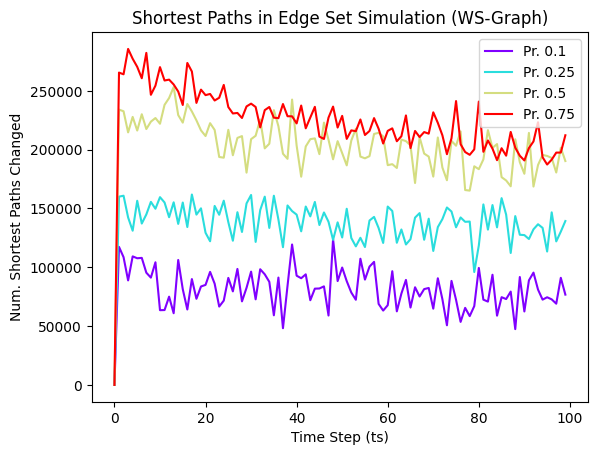

In [80]:
x = range(ts)
colours = plt.cm.rainbow(np.linspace(0, 1, len(Pr_range)))

fig = plt.figure()
for i in range(len(Pr_range)):
    plt.plot(x, paths_changed[i], color = colours[i], label = ("Pr. " + str(Pr_range[i])))
plt.legend()
plt.xlabel("Time Step (ts)")
plt.ylabel("Num. Shortest Paths Changed")
plt.title("Shortest Paths in Edge Set Simulation (WS-Graph)")
plt.show() 

fig.savefig('ES_ex1_paths.jpg')

**Dynamics of the Shortest Path Lengths: How much do the paths change?**: Dynamics in the case where the initial weight of any edge (i, j) is chosen uniformly in the range 0, 100.

How do the shortest path lengths change between time steps where edges are subject to random rewiring with probability Pr? 

**Experiment**

For a range of rewiring probabilities, by how much does the average path length change? 

In [106]:
pathlengths = []

for d_pr in distances:
    ts_pathlengths = []
    # Find the average pathlength at each time step
    for dts in d_pr:
        paths = 0
        total_pathlength = 0.0 
        
        # Find average path length based on output from Dijkstra's
        for dsrc in dts:
            paths += 1 
            total_pathlength += sum(dsrc.values()) 
        
        avg_pathlength = total_pathlength / paths
        ts_pathlengths.append(avg_pathlength)
    
    pathlengths.append(ts_pathlengths)

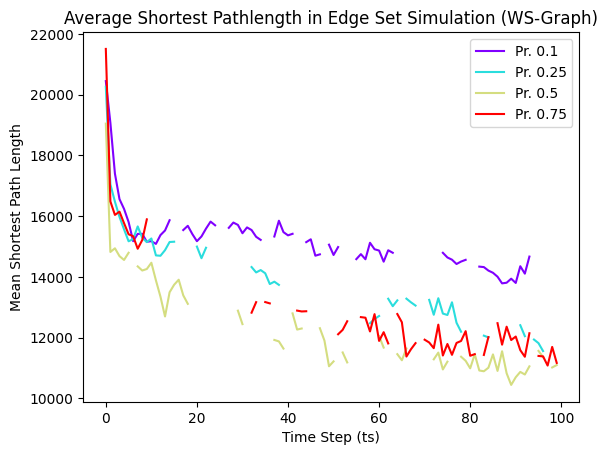

In [107]:
x = range(ts)
colours = plt.cm.rainbow(np.linspace(0, 1, len(Pr_range)))

fig = plt.figure()
for i in range(len(Pr_range)):
    plt.plot(x, pathlengths[i], color = colours[i], label = ("Pr. " + str(Pr_range[i])))
plt.legend()
plt.xlabel("Time Step (ts)")
plt.ylabel("Mean Shortest Path Length")
plt.title("Average Shortest Pathlength in Edge Set Simulation (WS-Graph)")
plt.show() 

fig.savefig('ES_ex2_length.jpg')